# 傅立叶卷积与卷积的对比实验

In [25]:
import torch
from torch.nn.functional import pad
import time
import matplotlib.pyplot as plot
from PIL import Image
from torchvision import transforms

## 1. 基础参数设置

In [13]:
"""
sc：图像的尺寸，不论输入图像尺寸多大一律调整为 sc*sc
scale：平铺的比例，比如 scale=3, 3*3 -> 9*9
ke_sc：有效卷积核的尺寸，比如 ke_sc=3*3
sc_ke_pad：满足频域等价卷积不重叠下的输入与卷积核尺寸，外圈补零，比如 inputs=sc*sc, ke_sc=3*3 -> sc_ke_pad=(sc+2)*(sc+2)
"""
sc = 101
scale = 3
ke_sc = 3
sc_ke_pad = sc + 2 * (ke_sc // 2)

## 2. 以输入图像中心在周围填充空白

In [14]:
"""
true：周围填充零的输入图像
k：频域
"""
path = r'/Users/WangHao/工作/纳米光子中心/全光相关/实验-0303/0303.png'
img_1 = Image.open(path).convert('L')
img_1 = transforms.Compose([transforms.ToTensor(), transforms.Resize((sc, sc))])(img_1).squeeze(0)
img_1_k = torch.fft.fftshift(torch.fft.fft2(img_1), dim=(-2, -1))
img_1_k_abs = torch.abs(img_1_k)
img_1_k_phase = img_1_k.angle()

img_tile_1 = torch.zeros((scale * sc_ke_pad, scale * sc_ke_pad))
img_tile_1[(scale // 2) * sc_ke_pad + (ke_sc // 2):(scale // 2 + 1) * sc_ke_pad - (ke_sc // 2),
           (scale // 2) * sc_ke_pad + (ke_sc // 2):(scale // 2 + 1) * sc_ke_pad - (ke_sc // 2)] \
           = img_1
img_tile_1_k = torch.fft.fftshift(torch.fft.fft2(img_tile_1), dim=(-2, -1))
img_tile_1_k_abs = torch.abs(img_tile_1_k)
img_tile_1_k_phase = img_tile_1_k.angle()

## 3. 设计卷积核

In [15]:
list_kernel = []
kernel_1 = torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
list_kernel.append(kernel_1)
kernel_2 = torch.tensor([[2, 0, 0], [0, -1, 0], [0, 0, -1]])
list_kernel.append(kernel_2)
kernel_3 = torch.tensor([[1 / 9, 1 / 9, 1 / 9], [1 / 9, 1 / 9, 1 / 9], [1 / 9, 1 / 9, 1 / 9]])
list_kernel.append(kernel_3)
kernel_4 = torch.tensor([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
list_kernel.append(kernel_4)
kernel_5 = torch.tensor([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
list_kernel.append(kernel_5)
kernel_6 = torch.tensor([[1, 1, 1], [1, -7, 1], [1, 1, 1]])
list_kernel.append(kernel_6)
kernel_7 = torch.tensor([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
list_kernel.append(kernel_7)
kernel_8 = torch.tensor([[0, 1, 0], [0, 1, 0], [0, 1, 0]])
list_kernel.append(kernel_8)
kernel_9 = torch.tensor([[-1, -1, 0], [-1, 0, 1], [0, 1, 1]])
list_kernel.append(kernel_9)

## 4. 使每个小卷积核均匀平铺与相应位置的输入中心对齐

In [16]:
kernel_tile_1 = torch.zeros((scale * sc_ke_pad, scale * sc_ke_pad))
k = 0
for r in range(scale):
    for c in range(scale):
        kernel_tile_1[(sc_ke_pad // 2 - ke_sc // 2) + sc_ke_pad * r:(sc_ke_pad // 2 + ke_sc // 2 + 1) + sc_ke_pad * r,
                      (sc_ke_pad // 2 - ke_sc // 2) + sc_ke_pad * c:(sc_ke_pad // 2 + ke_sc // 2 + 1) + sc_ke_pad * c] \
                      = list_kernel[k]
        k += 1

## 5. 通过傅里叶变换实现深度学习中的卷积计算以及直接执行深度学习卷积计算

In [17]:
kernel_tile_1_k = []
kernel_tile_1_k_abs = []
kernel_tile_1_k_phase = []
result_tile_1_k_abs = []
result_tile_1_k_phase = []
result_tile_1_fft_conv = []
n = 0
time_start = time.time_ns()
while n <= 0:
    kernel_tile_1_k = torch.fft.fftshift(torch.fft.fft2(kernel_tile_1), dim=(-2, -1))
    kernel_tile_1_k.imag *= -1
    n += 1
    kernel_tile_1_k_abs = torch.abs(kernel_tile_1_k)
    kernel_tile_1_k_phase = kernel_tile_1_k.angle()
    result_tile_1_k = img_tile_1_k * kernel_tile_1_k
    result_tile_1_k_abs = torch.abs(result_tile_1_k)
    result_tile_1_k_phase = result_tile_1_k.angle()
    result_tile_1_fft_conv = torch.abs(torch.fft.fftshift(torch.fft.ifft2(result_tile_1_k), dim=(-2, -1)))
time_end = time.time_ns()
time_fft_conv = time_end - time_start
print(time_fft_conv)

result_tile_1_conv = []
n = 0
time_start = time.time_ns()
while n <= 0:
    result_tile_1_conv = torch.conv2d(img_tile_1.unsqueeze(0).unsqueeze(0), kernel_tile_1.unsqueeze(0).unsqueeze(0),
                                      padding=kernel_tile_1.shape[-1] // 2).squeeze(0).squeeze(0)
    n += 1
time_end = time.time_ns()
time_conv = time_end - time_start
print(time_conv)

5826000
19367351000


## 6. 可视化开关

In [18]:
flag = True
if flag:
    [switch1, switch2, switch3, switch4] = [True, True, True, True]
else:
    [switch1, switch2, switch3, switch4] = [False, False, False, False]

### 6.1. 可视化输入图像填充前后及其频谱相谱

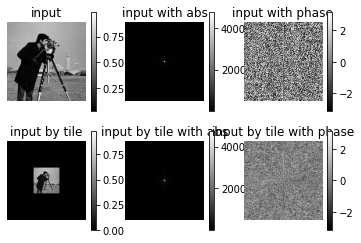

In [19]:
if switch1:
    fig1 = plot.figure(1)
    plot.subplot(2, 3, 1)
    plot.imshow(img_1, cmap='gray')
    plot.axis('off')
    plot.title('input')
    plot.colorbar()

    plot.subplot(2, 3, 2)
    plot.imshow(img_1_k_abs, cmap='gray')
    plot.axis('off')
    plot.title('input with abs')
    plot.colorbar()

    plot.subplot(2, 3, 3)
    plot.imshow(img_1_k_phase, cmap='gray')
    plot.axis('off')
    plot.title('input with phase')
    plot.colorbar()

    plot.subplot(2, 3, 4)
    plot.imshow(img_tile_1, cmap='gray')
    plot.axis('off')
    plot.title('input by tile')
    plot.colorbar()

    plot.subplot(2, 3, 5)
    plot.imshow(img_tile_1_k_abs, cmap='gray')
    plot.axis('off')
    plot.title('input by tile with abs')
    plot.colorbar()

    plot.subplot(2, 3, 6)
    plot.imshow(img_tile_1_k_phase, cmap='gray')
    plot.axis('off')
    plot.title('input by tile with phase')
    plot.colorbar()

    plot.show()

### 6.2. 可视化平铺卷积核与其频谱相谱

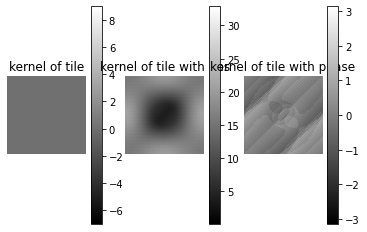

In [20]:
if switch2:
    fig2 = plot.figure(2)
    plot.subplot(1, 3, 1)
    plot.imshow(kernel_tile_1, cmap='gray')
    plot.axis('off')
    plot.title('kernel of tile')
    plot.colorbar()

    plot.subplot(1, 3, 2)
    plot.imshow(kernel_tile_1_k_abs, cmap='gray')
    plot.axis('off')
    plot.title('kernel of tile with abs')
    plot.colorbar()

    plot.subplot(1, 3, 3)
    plot.imshow(kernel_tile_1_k_phase, cmap='gray')
    plot.axis('off')
    plot.title('kernel of tile with phase')
    plot.colorbar()

    plot.show()

### 6.3. 可视化傅里叶卷积结果与卷积结果以及4f系统傅里叶面的振幅与相位

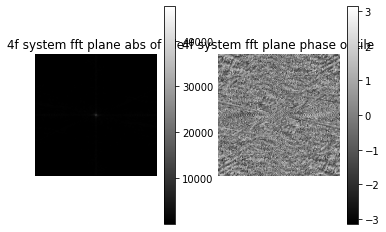

In [21]:
if switch3:
    fig3 = plot.figure(3)
    plot.subplot(1, 2, 1)
    plot.imshow(result_tile_1_k_abs, cmap='gray')
    plot.axis('off')
    plot.title('4f system fft plane abs of tile')
    plot.colorbar()

    plot.subplot(1, 2, 2)
    plot.imshow(result_tile_1_k_phase, cmap='gray')
    plot.axis('off')
    plot.title('4f system fft plane phase of tile')
    plot.colorbar()

    plot.show()

### 6.4. 可视化fft_conv与conv之间残差

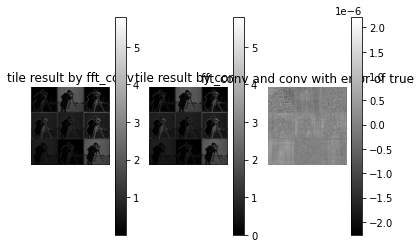

In [22]:
if switch4:
    fig4 = plot.figure(4)
    plot.subplot(1, 3, 1)
    plot.imshow(result_tile_1_fft_conv, cmap='gray')
    plot.axis('off')
    plot.title('tile result by fft_conv')
    plot.colorbar()

    plot.subplot(1, 3, 2)
    plot.imshow(torch.abs(result_tile_1_conv), cmap='gray')
    plot.axis('off')
    plot.title('tile result by conv')
    plot.colorbar()

    plot.subplot(1, 3, 3)
    plot.imshow(result_tile_1_fft_conv - torch.abs(result_tile_1_conv), cmap='gray')
    plot.axis('off')
    plot.title('fft_conv and conv with error of true')
    plot.colorbar()

    plot.show()

## 7. 频域取中心一半与频域补零扩展一倍

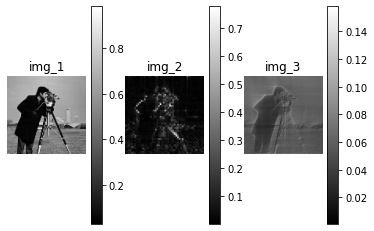

In [27]:
h, w = img_1.shape
img_2 = torch.fft.fftshift(torch.fft.fft2(img_1))[h // 2 - h // 4:h // 2 + h // 4, w // 2 - w // 4:w // 2 + w // 4]
img_2 = torch.fft.ifft2(img_2)
img_3 = torch.fft.fftshift(pad(torch.fft.fft2(img_1), [h, h, w, w], 'constant', (0. + 0.j)))
img_3 = torch.fft.ifft2(img_3)

fig5 = plot.figure(5)
plot.subplot(1, 3, 1)
plot.imshow(img_1, cmap='gray')
plot.title('img_1')
plot.colorbar()

plot.subplot(1, 3, 2)
plot.imshow(torch.abs(img_2), cmap='gray')
plot.title('img_2')
plot.colorbar()

plot.subplot(1, 3, 3)
plot.imshow(torch.abs(img_3), cmap='gray')
plot.title('img_3')
plot.colorbar()

plot.show()